In [6]:
"""
TODO:
- Get at least a reasonable looking change. Maybe start with bad initial conditions.
- Gg should be symmetric
- BFGS cannot handle constraints nor bounds
Jimin's: 
[0 8 5, 8 0 2, 5 2 0]
[0 2 8, 7 0 3, 7 7 0]
- Exciting excitatory
"""
import numpy as np
import project_path
from model.neural_model import NeuralModel

N = 3
# TODO: Update this to match Jimin's paper
is_inhibitory = np.array([1, 0 ,0])

def gen_random_connectome(N):
  """
  Return Gg (NxN), Gs (NxN)
  """
  Gg = np.random.rand(N,N)
  Gs = np.random.rand(N,N)
  
  return (Gg, Gs)

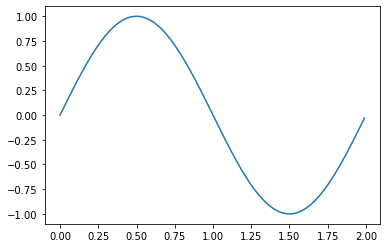

In [2]:
import pylab as plt

dt = 0.01
def get_gold_dynamics(dt):
  """
  Generate 1 period of the golden dynamics
  The return value is already discretized according to dt 
  """
  # Period length in s
  period_s = 2.0
  ts = np.arange(0, period_s, dt)
  return ts, np.sin((2 * np.pi / period_s) * ts)

ts, ys = get_gold_dynamics(dt)
plt.plot(ts, ys)

In [3]:
def ts_distance_euclidean(ts1, ts2):
  return np.linalg.norm(ts1 - ts2)
ts_distance_euclidean(np.array([1] * 5), np.array([0] * 5))

2.23606797749979

In [4]:
from sklearn.decomposition import PCA
import pdb

def unpack_param_vec(x):
  gg_vec = x[:N*N]
  gs_vec = x[N*N:2*N*N]
  gg_mat = gg_vec.reshape(N,N)
  gs_mat = gs_vec.reshape(N,N)
  return gg_mat, gs_mat

def run_neural_model(N, Gg, Gs, gold_dynamics):
  # Only the first neuron is receiving constant input
  I_ext = np.array([1.0] + [0] * (N-1))
  model = NeuralModel(
    N = N,
    Gg = Gg,
    Gs = Gs,
    is_inhibitory = is_inhibitory,
    I_ext = I_ext)
  
  # Run longer than gold_dynamics to allow trajectory to stabilize
  simul_ts = len(gold_dynamics) * 2
  (v_mat, s_mat, v_normalized_mat) = model.run(simul_ts)

  # Reduce dimension of model dynamics
  pca = PCA(n_components = 1)
  projected_X = pca.fit_transform(v_normalized_mat)

  # First PCA comp, and just the last bits
  normalized_run_dyn = projected_X[len(gold_dynamics):,0]
  return normalized_run_dyn

def create_obj_fun(N, gold_dynamics):
  def obj_fun(x):
    gg_mat, gs_mat = unpack_param_vec(x)
    normalized_run_dyn = run_neural_model(N, gg_mat, gs_mat, gold_dynamics)
    error = ts_distance_euclidean(gold_dynamics, normalized_run_dyn)
    return error
  return obj_fun

Total runtime = 0.04s
Error before optimization = 17.262727404590017


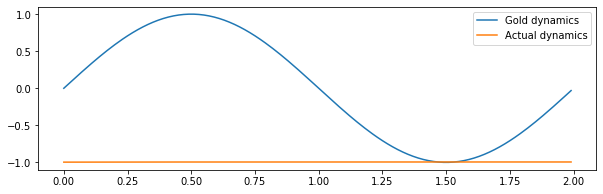

In [7]:
# Initial run
dt = 0.01
Gg, Gs = gen_random_connectome(N)
ts, gold_dynamics = get_gold_dynamics(dt)

normalized_run_dyn = run_neural_model(N, Gg, Gs, gold_dynamics)
error = ts_distance_euclidean(gold_dynamics, normalized_run_dyn)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(ts, gold_dynamics, label = "Gold dynamics")
ax.plot(ts, normalized_run_dyn, label = "Actual dynamics")
ax.legend()
print("Error before optimization = " + str(error))

In [8]:
# Optimize
from scipy.optimize import minimize

obj_fun = create_obj_fun(N, gold_dynamics)
bnds = [(0, None)] * (2 * N**2 + N)
init_cond_arr = np.concatenate([Gg.flatten(), Gs.flatten()])

res = minimize(obj_fun, init_cond_arr, method='BFGS', bounds=bnds)
print(res)

/home/stephen/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  RuntimeWarning)


Total runtime = 0.05s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.05s
Total runtime = 0.05s
Total runtime = 0.05s
Total runtime = 0.05s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.04s
Total runtime = 0.04s
Total runtime = 0.04s
Total runtime = 0.04s
Total runtime = 0.05s
Total runtime = 0.05s
Total runtime = 0.05s
Total runtime = 0.05s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.03s
Total runt

Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runt

/home/stephen/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


Total runtime = 0.04s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.04s
Total runtime = 0.03s
Total runtime = 0.03s
Total runtime = 0.03s
Total runt

Total runtime = 0.04s
Error after optimization = 17.259447484812036


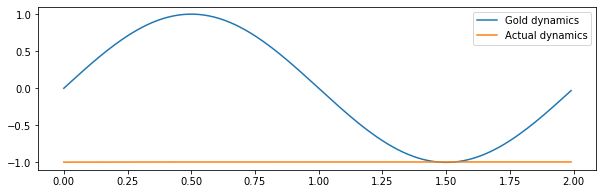

In [9]:
# Plot the optimized results
new_Gg, new_Gs = unpack_param_vec(res.x)

normalized_run_dyn = run_neural_model(N, new_Gg, new_Gs, gold_dynamics)
error = ts_distance_euclidean(gold_dynamics, normalized_run_dyn)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(ts, gold_dynamics, label = "Gold dynamics")
ax.plot(ts, normalized_run_dyn, label = "Actual dynamics")
ax.legend()
print("Error after optimization = " + str(error))